In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('600340', start='2021-07-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df



本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
108,2021-07-01,5.22,5.21,5.34,5.19,411681.0,600340
109,2021-07-02,5.18,5.06,5.20,5.05,424908.0,600340
110,2021-07-05,5.07,5.12,5.19,4.99,366979.0,600340
111,2021-07-06,5.10,5.36,5.44,5.09,932561.0,600340
112,2021-07-07,5.30,5.40,5.44,5.28,635756.0,600340
...,...,...,...,...,...,...,...
223,2021-12-27,3.68,3.65,3.74,3.63,478086.0,600340
224,2021-12-28,3.82,3.67,3.96,3.66,850325.0,600340
225,2021-12-29,3.62,3.61,3.64,3.57,520226.0,600340
226,2021-12-30,3.60,3.57,3.63,3.56,420788.0,600340


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
108,5.22,5.21
109,5.18,5.06
110,5.07,5.12
111,5.10,5.36
112,5.30,5.40
...,...,...
223,3.68,3.65
224,3.82,3.67
225,3.62,3.61
226,3.60,3.57


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.77732794, 0.78278689],
       [0.7611336 , 0.72131148],
       [0.71659919, 0.74590164],
       [0.72874494, 0.8442623 ],
       [0.8097166 , 0.86065574],
       [0.84615385, 1.        ],
       [0.951417  , 0.97540984],
       [1.        , 0.8852459 ],
       [0.89068826, 0.8852459 ],
       [0.87044534, 0.80737705],
       [0.78947368, 0.78278689],
       [0.77327935, 0.7704918 ],
       [0.75303644, 0.7704918 ],
       [0.69635628, 0.7295082 ],
       [0.72064777, 0.71311475],
       [0.70850202, 0.70901639],
       [0.70445344, 0.67213115],
       [0.66396761, 0.55737705],
       [0.55465587, 0.45901639],
       [0.44534413, 0.38934426],
       [0.40080972, 0.40163934],
       [0.39676113, 0.42213115],
       [0.37246964, 0.4057377 ],
       [0.39271255, 0.39344262],
       [0.38461538, 0.3647541 ],
       [0.36032389, 0.37295082],
       [0.36032389, 0.3442623 ],
       [0.33603239, 0.37704918],
       [0.37246964, 0.41393443],
       [0.41700405, 0.43032787],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(90, 2)
(30, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(70, 14, 2)
(70, 1)
(10, 14, 2)
(10, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
2/2 [==============================] - 6s 1s/step - loss: 0.1154 - val_loss: 0.0960
Epoch 2/10
2/2 [==============================] - 0s 55ms/step - loss: 0.0808 - val_loss: 0.0555
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 0.0572 - val_loss: 0.0381
Epoch 4/10
2/2 [==============================] - 0s 43ms/step - loss: 0.0500 - val_loss: 0.0468
Epoch 5/10
2/2 [==============================] - 0s 41ms/step - loss: 0.0599 - val_loss: 0.0429
Epoch 6/10
2/2 [==============================] - 0s 46ms/step - loss: 0.0554 - val_loss: 0.0381
Epoch 7/10
2/2 [==============================] - 0s 52ms/step - loss: 0.0507 - val_loss: 0.0429
Epoch 8/10
2/2 [==============================] - 0s 44ms/step - loss: 0.0498 - val_loss: 0.0508
Epoch 9/10
2/2 [==============================] - 0s 41ms/step - loss: 0.0542 - val_loss: 0.0569
Epoch 10/10
2/2 [==============================] - 0s 48ms/step - loss: 0.0560 - val_loss: 0.0588


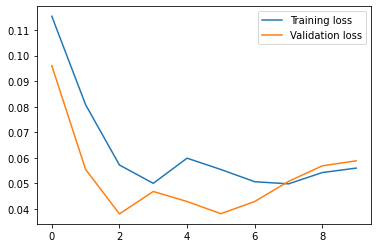

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 1s 1s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48681/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

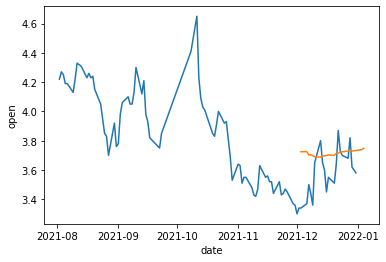

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [248]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("600340_HXXF.csv")

In [15]:
df.to_csv("600340_HXXF.csv")